# Experiment 4: sqlite-vec query only

In [1]:
import os

import cv2
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import sqlite3
import sqlite_vec
import struct

from tqdm.notebook import tqdm
from torchvision import transforms
from PIL import Image
from ultralytics import YOLO

from face_alignment import align


In [2]:
# Define preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load face embedding model
model_face_embedding = torch.hub.load('otroshi/edgeface', 'edgeface_s_gamma_05', source='github', pretrained=True)

# Move the model to the GPU if available
model_face_embedding = model_face_embedding.to(device)

# Set model to eval
model_face_embedding.eval()

print(f"Model is loaded on {device}")


Using cache found in /root/.cache/torch/hub/otroshi_edgeface_main


Model is loaded on cuda


In [4]:
# Load SQLite database
db_path = "database/exp3.db"
conn = sqlite3.connect(db_path)
conn.enable_load_extension(True)
sqlite_vec.load(conn)
conn.enable_load_extension(False)

# Check SQLite and sqlite-vec version
sqlite_version, vec_version = conn.execute(
    "SELECT sqlite_version(), vec_version()"
).fetchone()
print(f"SQLite Version: {sqlite_version}, sqlite-vec Version: {vec_version}")


SQLite Version: 3.37.2, sqlite-vec Version: v0.1.6


In [5]:
# Function to serialize embeddings
def serialize_f32(vector):
    """Serialize a list of floats into raw bytes for storage."""
    return struct.pack("%sf" % len(vector), *vector)


In [6]:
# Function to find similar images
def find_similar_images(query_embedding, top_n=5):
    query_vector = serialize_f32(query_embedding)
    rows = conn.execute(
        """
        SELECT rowid, name, file_dir, distance
        FROM images
        WHERE embedding MATCH ?
        AND k = ?
        ORDER BY distance
        """,
        (query_vector, top_n),
    ).fetchall()
    
    return rows


/app/embedding_retrieval_demo/face_alignment/mtcnn_pytorch/src/matlab_cp2tform.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  r, _, _, _ = lstsq(X, U)


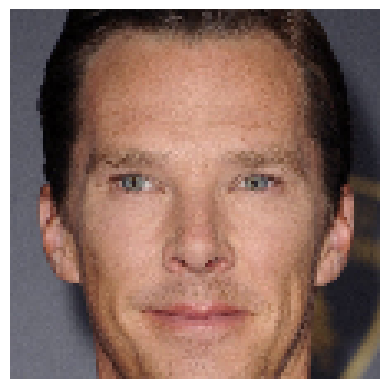

Top similar images:
(1, 'Benedict_Cumberbatch', 'dataset/IMDb-Face_clean_unique/images/nm1212722/1.jpg', 0.16082042455673218)


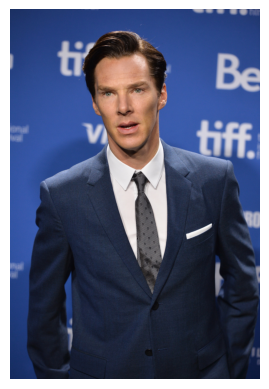

(72, 'Michael_Caton-Jones', 'dataset/IMDb-Face_clean_unique/images/nm0001994/1.jpg', 0.6835537552833557)


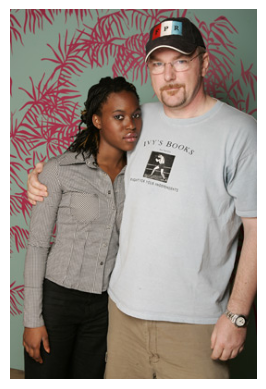

(64, 'Jed', 'dataset/IMDb-Face_clean_unique/images/nm1082505/1.jpg', 0.7066330909729004)


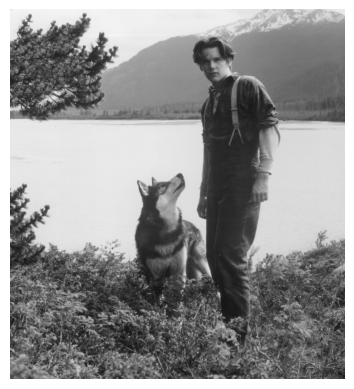

(77, 'Kelly_Marcel', 'dataset/IMDb-Face_clean_unique/images/nm2813876/1.jpg', 0.7260940074920654)


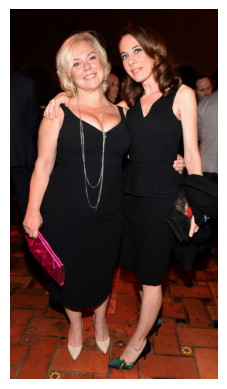

(31, 'Kristoffer_Joner', 'dataset/IMDb-Face_clean_unique/images/nm6206258/1.jpg', 0.7682504653930664)


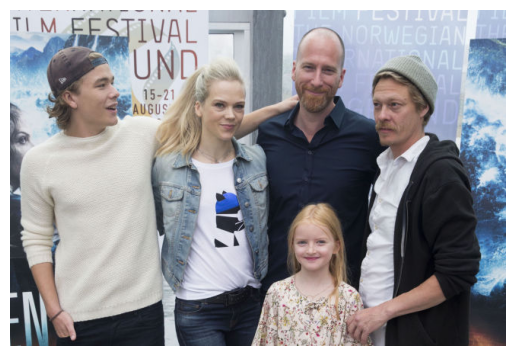

In [7]:
# Example: Query with a specific face embedding (e.g., first embedding in the list)
# query_embedding = embeddings_list[0]  # Let's use the first image's embedding as the query
image_path = "test_images/benedict cumberbatch_1.jpg"
input_image = cv2.imread(image_path)

# Convert the image to RGB
input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

pil_image = Image.fromarray(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
aligned = align.get_aligned_face(None, pil_image)  # align face

# Plot the image
plt.imshow(aligned)
plt.axis("off")  # Hide axis
plt.show()

if aligned is not None:
    transformed_input = transform(aligned).unsqueeze(0).to(device)  # preprocessing
    face_embedding = model_face_embedding(transformed_input).cpu().detach().numpy().flatten()

    query_embedding = face_embedding
    query_results = find_similar_images(query_embedding)

    print("Top similar images:")
    for query in query_results:
        print(query)

        image = cv2.imread(query[2])

        # Plot Image
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis("off")  # Hide axis
        plt.show()
else:
    print("invalid alignment")

